# Interpreting ResNet CIFAR-10 Training Process With Forgetting Events

This notebook trains a ResNet model using CIFAR-10 dataset and employed Forgetting Events algorithm, specifically `ForgettingEventsInterpreter`, to investigate the training process. A **forgetting event** occurrs when an individual training example transitions from being classified correctly to incorrectly over the course of learning. Some examples are forgotten frequently while others are not. This will help us understand whilch training example is more helpful for generalization performaces.

In [1]:
import paddle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import interpretdl as it

Define the training dataset using the CIFAR10 dataset generator from **paddle.vision.datasets**.

In [2]:
from paddle.vision.transforms import Transpose
from paddle.vision.datasets import Cifar10

train_dataset = Cifar10(mode='train', transform=Transpose())

Initialize the ResNet50 model using **paddle.vision.models**.

In [3]:
from paddle.vision.models import resnet50
model = resnet50(pretrained=False, num_classes=10)

Set up a data loader with batch size of 128, and an Momentum optimizer for training.

**Note:** the data generator shoud be able to generate the index of each sample, the sample and its label, so that each sample's behavior can be recorded according to its index.

In [4]:
def reader_prepare(dataset):
    def reader():
        counter_ = -1
        for sample, label in dataset:
            counter_ += 1
            yield counter_, (sample / 255.0).astype(np.float32), int(label)

    return reader

BATCH_SIZE = 128
train_reader = paddle.batch(
    reader_prepare(train_dataset), batch_size=BATCH_SIZE)
optimizer = paddle.optimizer.Momentum(learning_rate=0.001,
                     momentum=0.9,
                     parameters=model.parameters())

First initialize the `ForgettingEventsInterpreter` and then start `interpret`ing the training process by training 100 epochs. 

*stats* is a dictionary that maps image index to predictions in the training process and if they are correct; *count_forgotten* is a dictionary where its keys are number of fogotten times and values are a list of image indices with such number of fogotten times; *forgotten* is a dictionary that maps image index to an array of misclassified labels. They are saved at "assets/stats.pkl", "assets/count_forgotten.pkl" and "assets/forgotten.pkl".

In [6]:
fe = it.ForgettingEventsInterpreter(model, device='gpu:0')

epochs = 100
print('Training %d epochs. This may take some time.' % epochs)
stats, (count_forgotten, forgotten) = fe.interpret(
    train_reader,
    optimizer,
    batch_size=BATCH_SIZE,
    epochs=epochs,
    save_path='assets')

Training 100 epochs. This may take some time.
| Epoch [  1/100] Iter[  2]		Loss: 3.6884 Acc@1: 9.766%%

/opt/conda/envs/paddle2.0/lib/python3.7/site-packages/paddle/nn/layer/norm.py:636: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



| Epoch [ 93/100] Iter[348]		Loss: 0.0000 Acc@1: 100.000%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In the cell below, 9 most frequently forgotten samples and 9 never forgotten samples are visualized.

['0 - airplance', '1 - automobile', '2 - bird', '3 - cat', '4 - deer', '5 - dog', '6 - frog', '7 - horse', '8 - ship', '9 - truck']
The most frequently forgotten samples: 


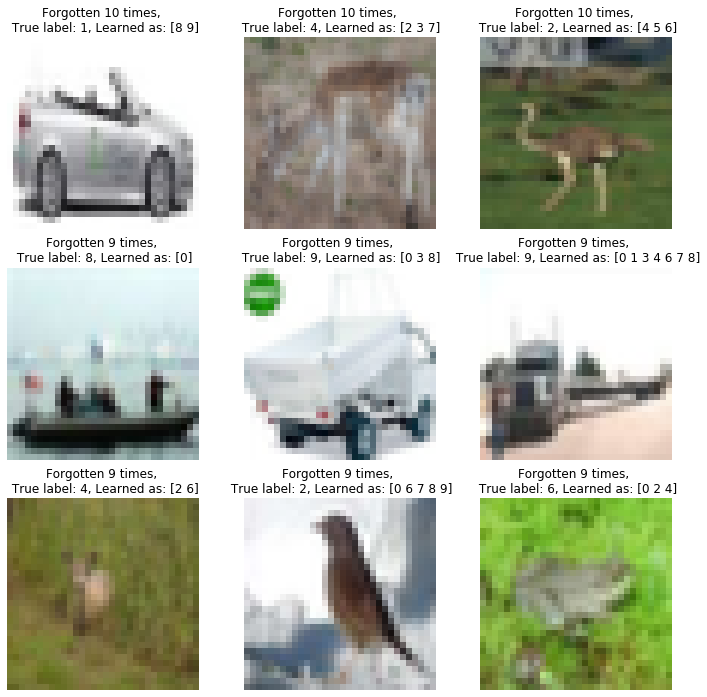

Number of never forgotten samples is 11997.


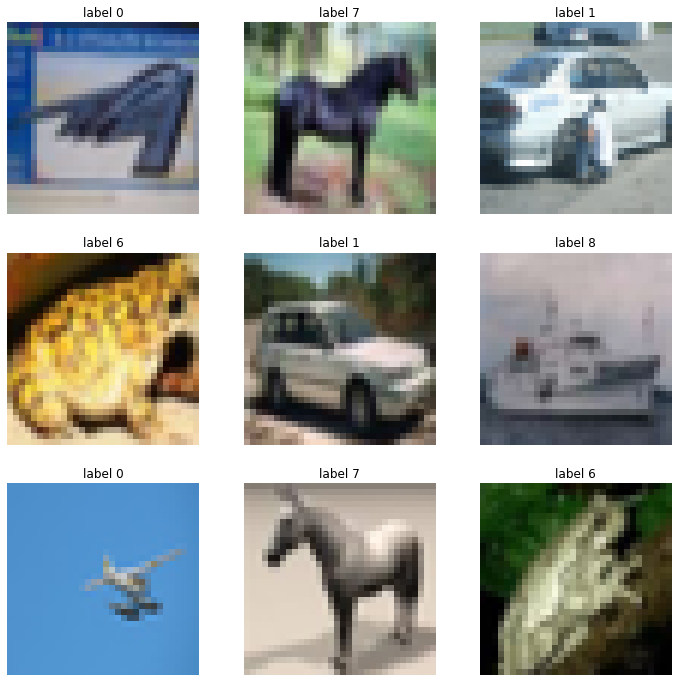

In [7]:
print([
        '0 - airplance', '1 - automobile', '2 - bird', '3 - cat', '4 - deer',
        '5 - dog', '6 - frog', '7 - horse', '8 - ship', '9 - truck'
    ])

max_count = max(count_forgotten.keys())
max_count_n = len(count_forgotten[max_count])

show_n = 9
count = 0
fig = plt.figure(figsize=(12, 12))
axes = []
print('The most frequently forgotten samples: ')
for k in np.sort(np.array(list(count_forgotten.keys())))[::-1]:
    for idx, i in enumerate(count_forgotten[k][:show_n - count]):
        x = train_dataset[i][0].reshape((3, 32, 32)).transpose((1, 2, 0))
        axes.append(fig.add_subplot(3, 3, idx + count + 1))
        axes[-1].set_title(
            'Forgotten {} times, \n True label: {}, Learned as: {}'.format(
                k, train_dataset[i][1], np.unique(forgotten[i])))
        axes[-1].axis('off')
        plt.imshow(x)
    count += len(count_forgotten[k][:show_n - count])
    if count >= show_n:
        break
plt.show()

axes = []
fig = plt.figure(figsize=(12, 12))
zero_count_n = len(count_forgotten.get(0, []))
print('Number of never forgotten samples is %d.' % (zero_count_n))
for idx, i in enumerate(count_forgotten.get(0, [])[:show_n]):
    x = train_dataset[i][0].reshape((3, 32, 32)).transpose((1, 2, 0))
    axes.append(fig.add_subplot(3, 3, idx + 1))
    axes[-1].set_title('label {}'.format(train_dataset[i][1]))
    axes[-1].axis('off')
    plt.imshow(x)
plt.show()